<a href="https://colab.research.google.com/github/monanjo123/pneumonia-classifier/blob/master/Pneumonia_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import math
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
import zipfile
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from google.colab.patches import cv2_imshow

# Load Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# unzip dataset zip file
local_zip = '/content/drive/My Drive/Machine Learning/datasets/ChestXRay2017.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/content/drive/My Drive/Machine Learning/datasets/")
zip_ref.close()

In [12]:
train_data_dir = "/content/drive/My Drive/Machine Learning/datasets/chest_xray/train"
validation_data_dir = "/content/drive/My Drive/Machine Learning/datasets/chest_xray/test"

img_rows, img_cols = 299 , 299

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
# Re-loads the InceptionV3 model without the top or FC layers
inception = InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape= (img_rows, img_cols, 3))

# Freeze the last 4 layers
for layer in inception.layers:
  layer.trainable = False
  
# Print layers
for (i,layer) in enumerate(inception.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization False
47 Batc

In [0]:
def addTopModel(bottom_model, num_classes):
  """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
  
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(256, activation='relu')(top_model)
  top_model = Dropout(0.3)(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)    
  return top_model

In [19]:
# Add FC Head to InceptionV3

num_classes = 2

FC_head = addTopModel(inception, num_classes)

model = Model(inputs=inception.input, outputs=FC_head)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
____________________________________________________________________________________________

# Train Model

In [20]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/Machine Learning/Models/pneumonia_inception_v3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# Note we use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.0001),
              metrics = ['accuracy'])

nb_train_samples = 5232
nb_validation_samples = 624
epochs = 30
batch_size = 32

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/30
163/163 [==============================] - 196s 1s/step - loss: 0.3661 - acc: 0.8330 - val_loss: 1.2714 - val_acc: 0.6234

Epoch 00001: val_loss improved from inf to 1.27135, saving model to /content/drive/My Drive/Machine Learning/Models/pneumonia_inception_v3.h5
Epoch 2/30
163/163 [==============================] - 190s 1s/step - loss: 0.2764 - acc: 0.8867 - val_loss: 0.8906 - val_acc: 0.6402

Epoch 00002: val_loss improved from 1.27135 to 0.89059, saving model to /content/drive/My Drive/Machine Learning/Models/pneumonia_inception_v3.h5
Epoch 3/30
163/163 [==============================] - 188s 1s/step - loss: 0.2486 - acc: 0.8997 - val_loss: 1.1317 - val_acc: 0.6233

Epoch 00003: val_loss did not improve from 0.89059
Epoch 4/30
163/163 [==============================] - 187s 1s/step - loss: 0.2217 - acc: 0.9095 - val_loss: 1.3147 - val_acc: 0.6351

Epoch 00004: val_loss did not improve from 0.89059
Epoch 5/30
163/163 [==============================] - 187s 1s/step - loss:

# Test Model

{'[0]': 'NORMAL', '[1]': 'PNEUMONIA'}
[1]


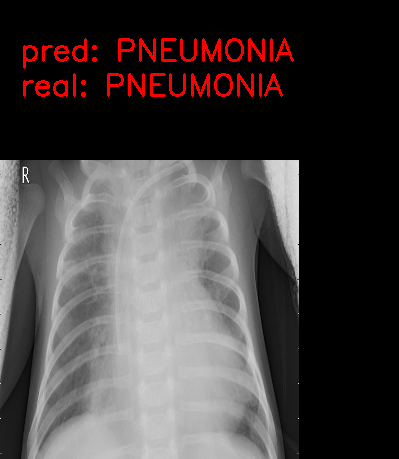


[0]


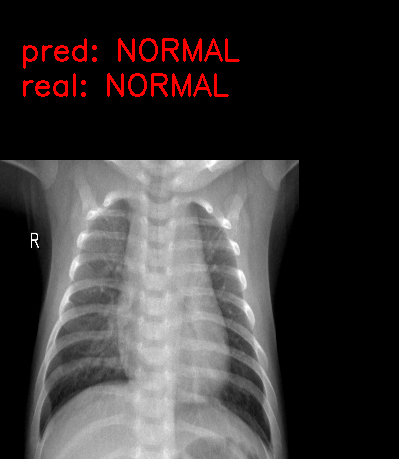


[1]


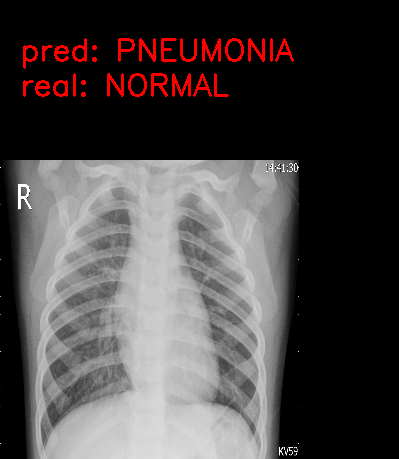


[1]


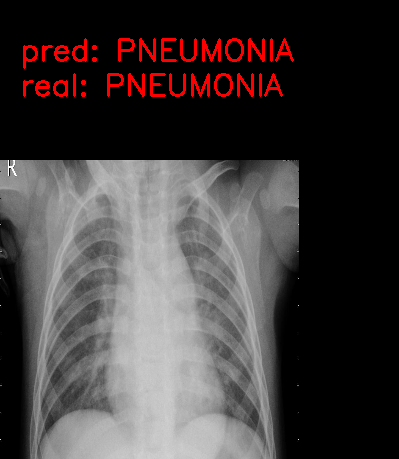


[1]


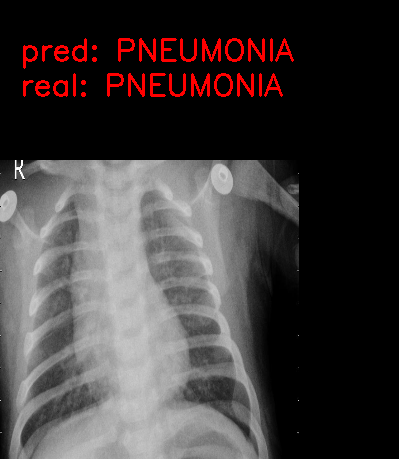


[1]


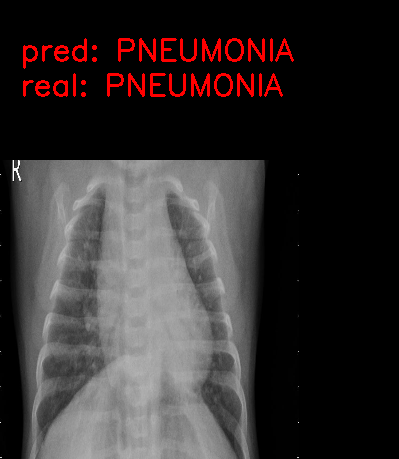


[1]


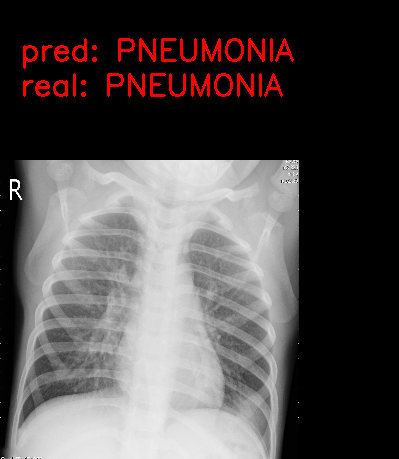


[1]


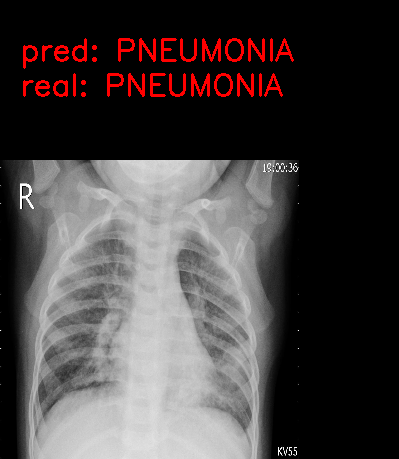


[1]


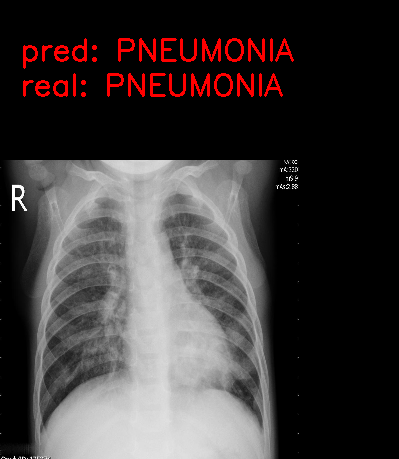


[1]


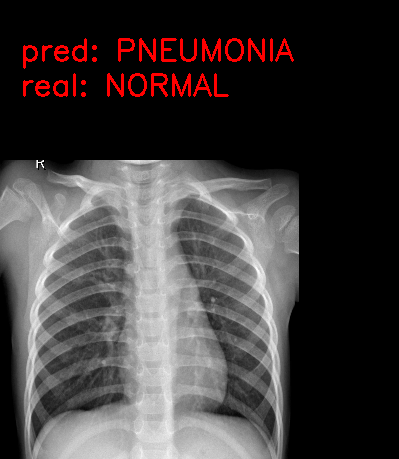


[0]


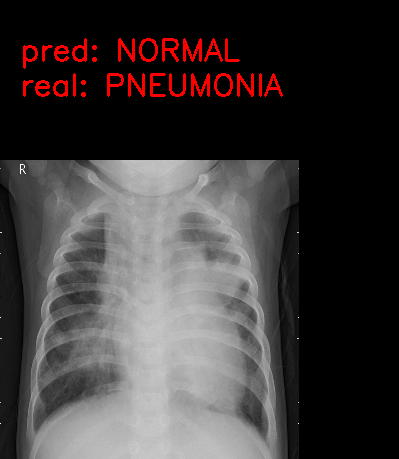


[1]


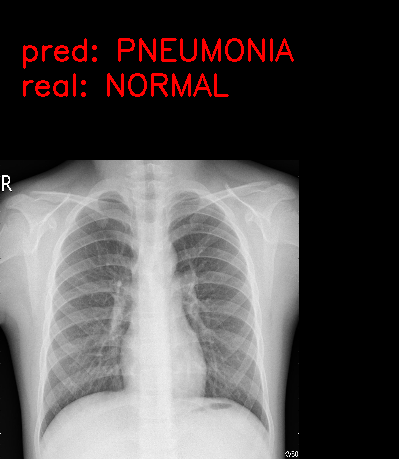


[1]


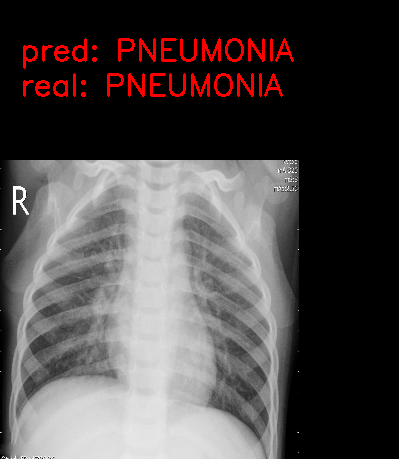


[1]


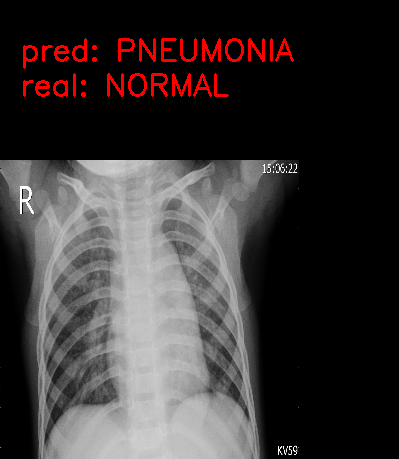


[1]


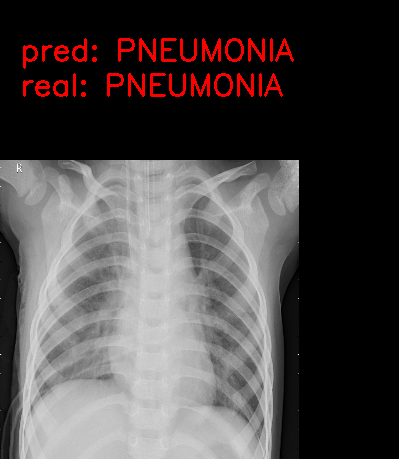


[1]


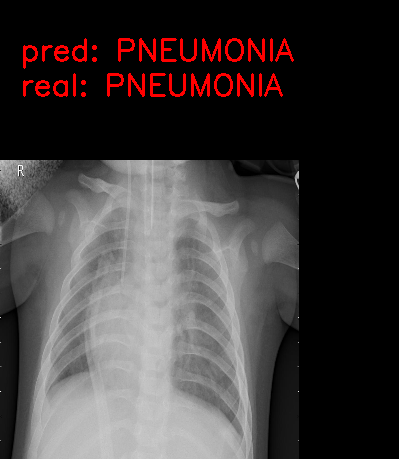


[1]


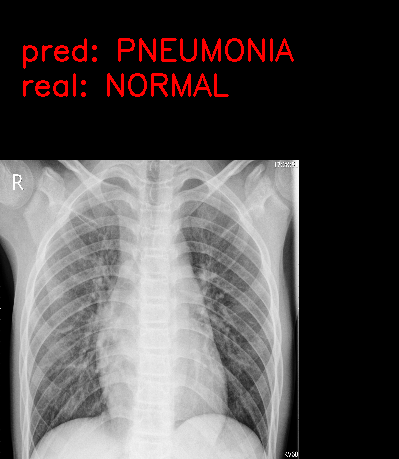


[1]


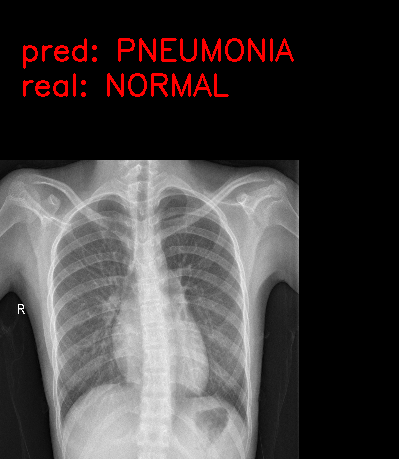


[1]


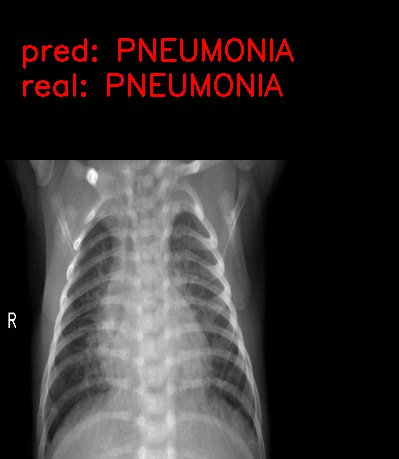


[1]


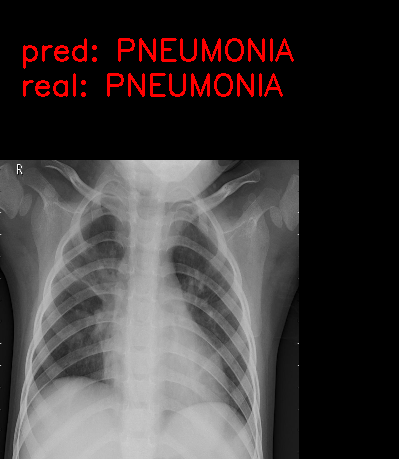


[1]


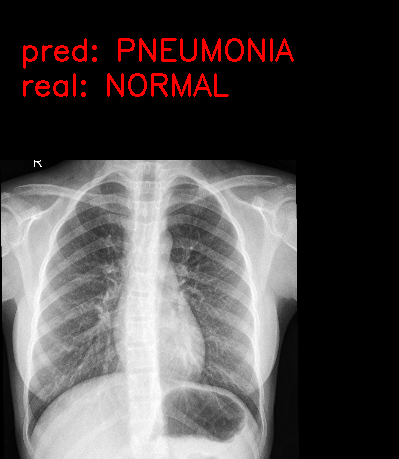


[0]


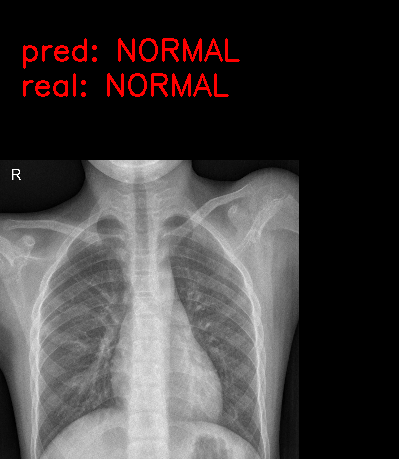


[1]


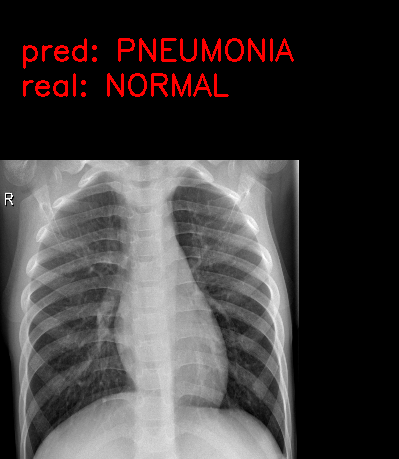


[1]


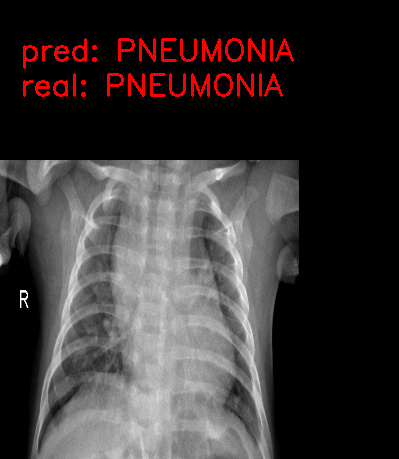


[1]


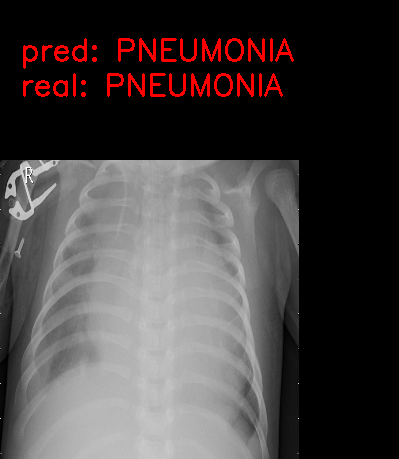


[1]


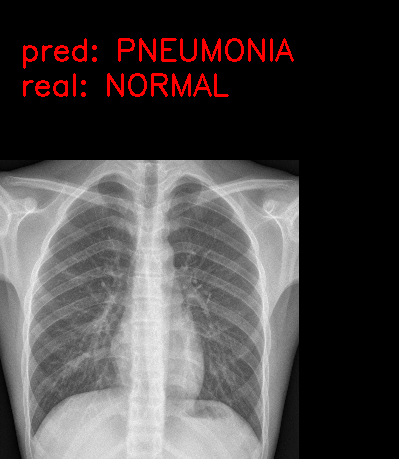


[1]


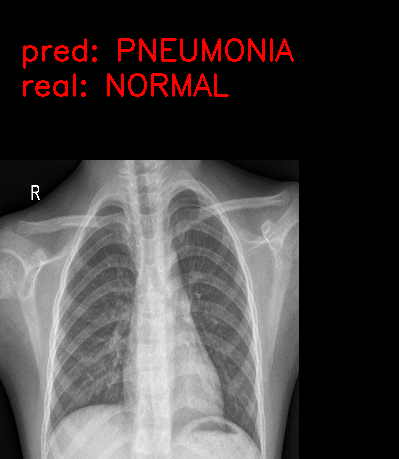


[1]


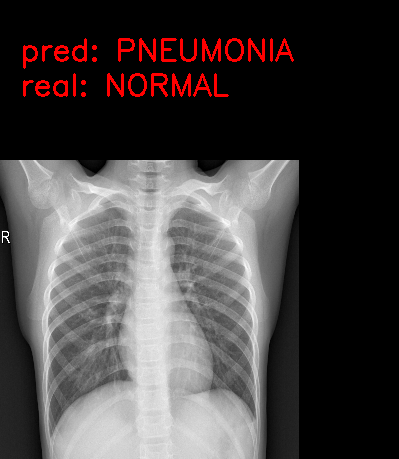


[1]


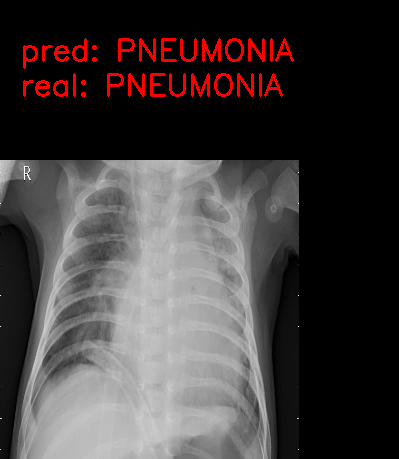


[1]


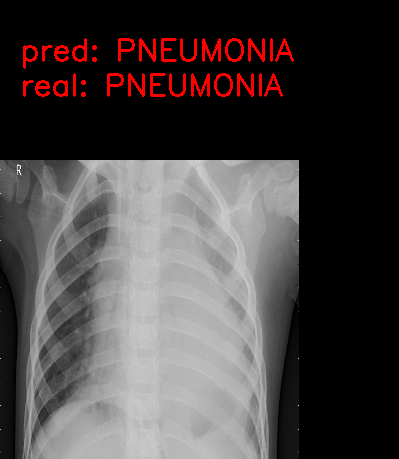


[1]


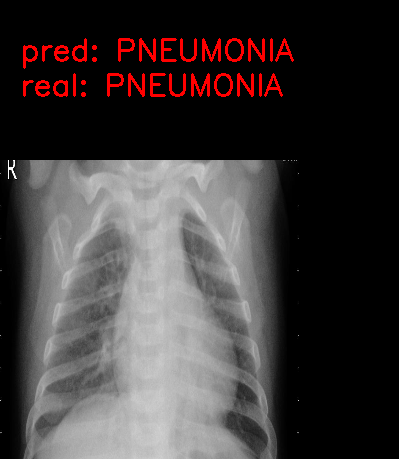


[0]


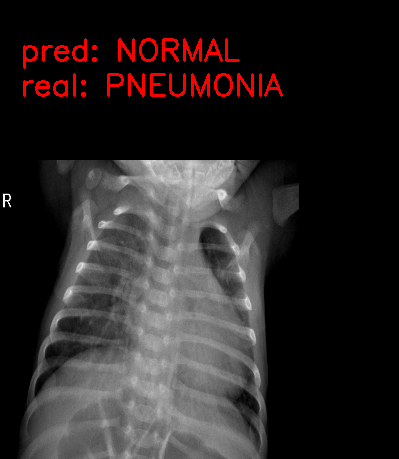


[1]


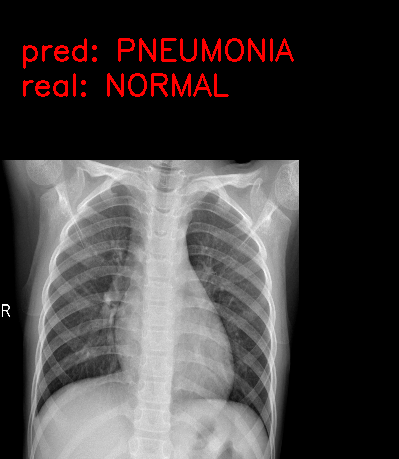


[1]


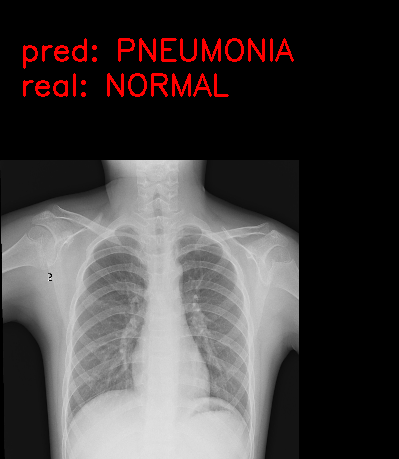


[1]


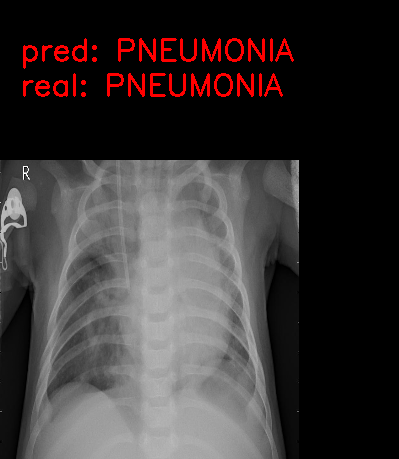


[1]


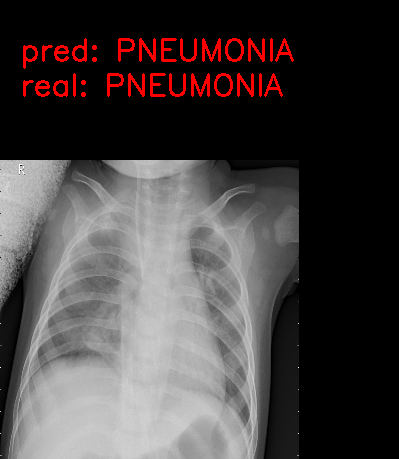


[1]


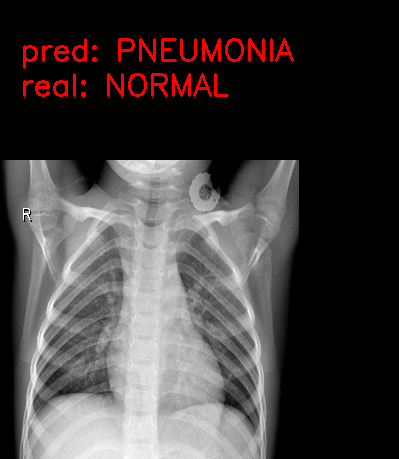


[1]


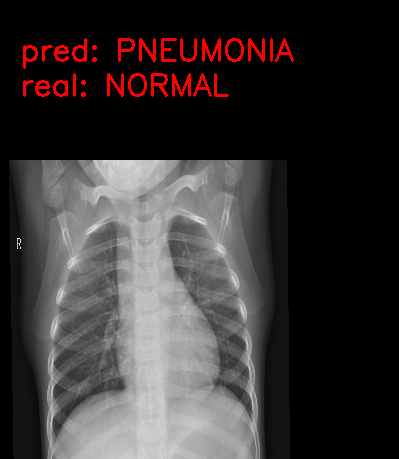


[1]


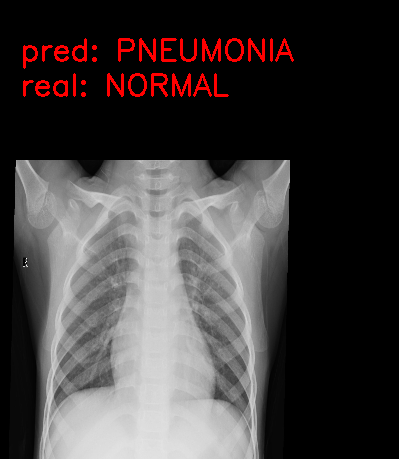


[1]


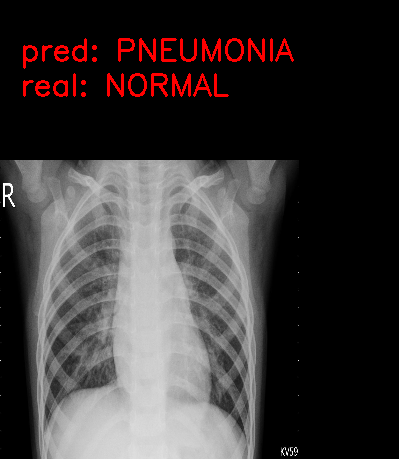


[1]


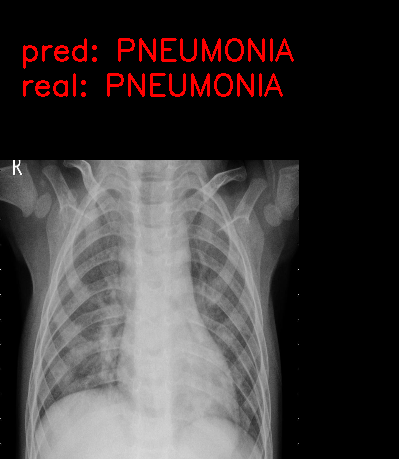


[1]


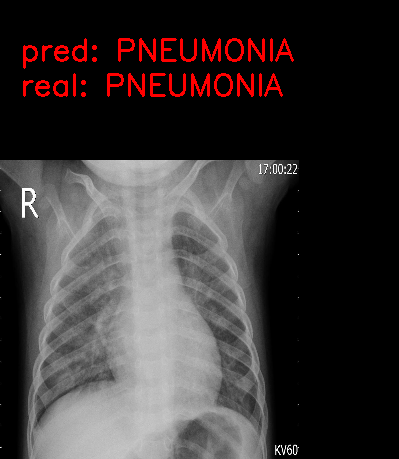


[1]


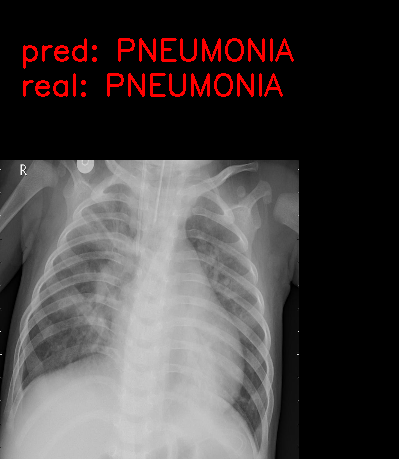


[1]


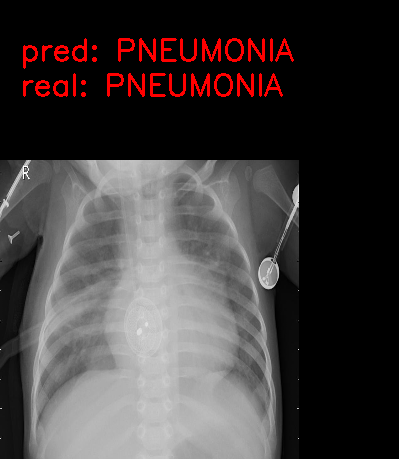


[1]


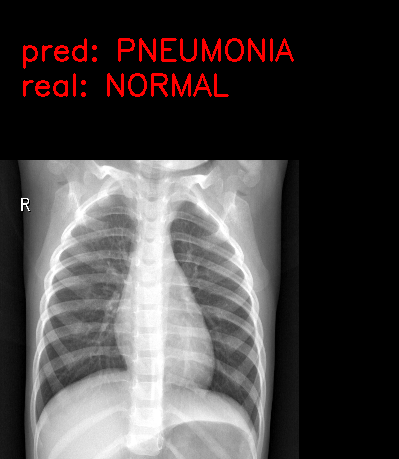


[1]


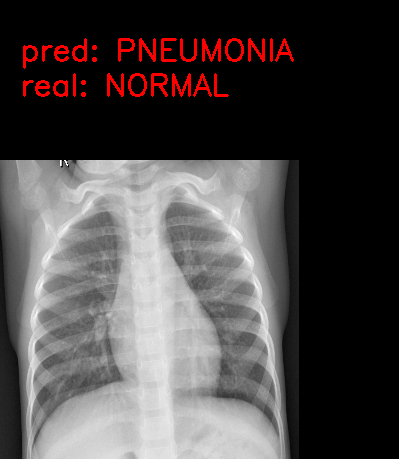


[1]


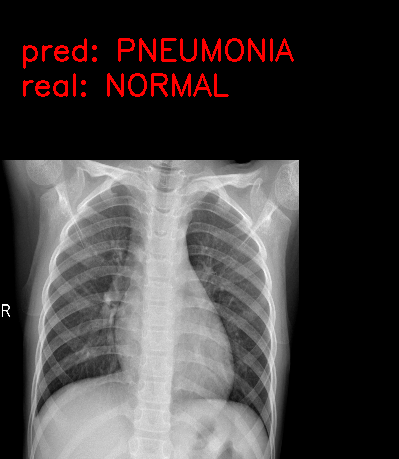


[1]


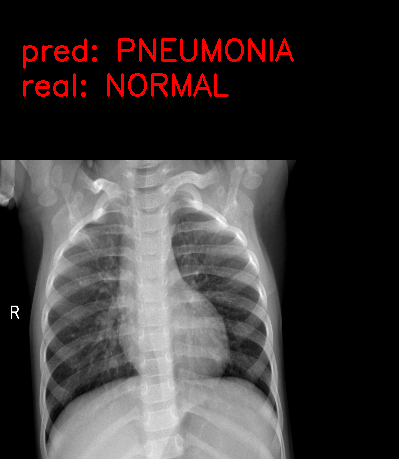


[1]


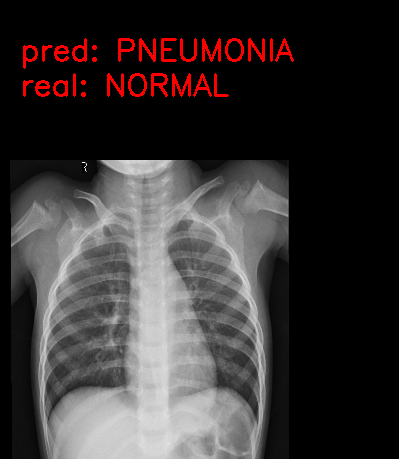


[1]


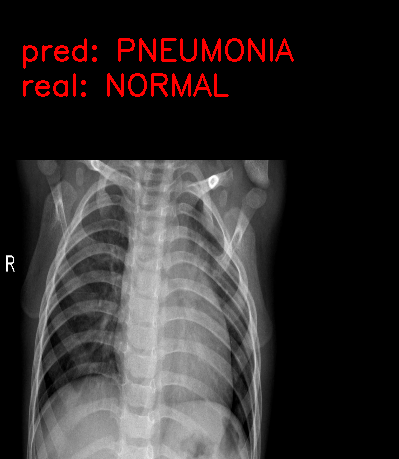

In [32]:
# Load Model
classifier = load_model('/content/drive/My Drive/Machine Learning/Models/pneumonia_inception_v3.h5')
folder_names = list(filter(lambda x: os.path.isdir(os.path.join(validation_data_dir + '/', x)), os.listdir(validation_data_dir + '/')))
folder_names.sort()
# print(folder_names)
className = ''
classification = {}
for i in range(len(folder_names)):
  key = '[{}]'.format(i)
  value = folder_names[i]
  classification[key] = value
print(classification)

def draw_test(name, pred, val, im):
    pneumonia = 'pred: ' + classification[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, pneumonia, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "real: " + val, (20, 95) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2_imshow(expanded_image)
    
def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name), str(path_class)

for i in range(0,50):
    input_im, val = getRandomImage(validation_data_dir + '/')
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, (img_rows, img_cols), fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (img_rows, img_cols), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,img_rows,img_cols,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    print(res)
    # Show image with predicted class
    draw_test("Prediction", res, val, input_original)
    
    print('')